<a href="https://colab.research.google.com/github/cfoli/AI-4-Financial-Modeling/blob/main/ANN_Worksheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np

# Binary Classification with Sonar Dataset: Standardized Smaller
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import utils
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import numpy as np

# load dataset
dataset = pd.read_csv("sonar.all-data", header=None).values

# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]

# encode class values as integers
encoder   = preprocessing.LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# One-hot encoding
# encoded_Y      = utils.to_categorical(encoded_Y)

num_classes  = np.unique(Y).size
input_shape = (X.shape[1],)


def build_graspnet(input_shape, dropoutRate=.25):

    input_layer   = layers.Input(shape = input_shape)
    input_layer   = layers.BatchNormalization()(input_layer)

    block1       = layers.Dense(units=64, name = 'hidden1')(input_layer)
    block1       = layers.BatchNormalization()(block1)
    block1       = layers.Activation('relu')(block1)
    block1       = layers.Dropout(rate=dropoutRate)(block1)

    model_output = layers.Dense(units=1, name = 'output_layer')(block1)
    model_output = layers.Activation('sigmoid')(model_output)

    model = Model(inputs=input_layer, outputs=model_output)

	# Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# Perform cross-validation manually
for train_idx, test_idx in kfold.split(X_scaled, encoded_Y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    Y_train, Y_test = encoded_Y[train_idx], encoded_Y[test_idx]

    # Create and fit the model
    model = build_graspnet(input_shape=input_shape, dropoutRate=.5)
    model.fit(X_train, Y_train, epochs=150, batch_size=96, verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, Y_test, verbose=1)
    scores.append(accuracy)

print(f"CVDA: {np.mean(scores) * 100:.2f}% (+/- {np.std(scores) * 100:.2f}%)")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7475 - loss: 0.5465  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8686 - loss: 0.3370  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7842 - loss: 0.7526  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7599 - loss: 0.3815  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.8399 - loss: 0.5734
CVDA: 81.25% (+/- 4.62%)


In [ ]:
# !pip install scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.8 MB/s eta 0:00:00


In [ ]:
# encoded_Y
X.shape

(208, 60)

# MLP (MNIST: SEQUENTIAL API)

In [ ]:
import numpy as np
import keras_tuner
import keras
from keras import layers

###-------------------------- BUILD MODEL -------------------------###
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# build_model(keras_tuner.HyperParameters())


###---------------- PARTITION DATA INTO TRAIN/VALIDATE/TEST ----------###
(x, y), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x[:-10000]
x_val   = x[-10000:]
y_train = y[:-10000]
y_val   = y[-10000:]

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_val   = np.expand_dims(x_val, -1).astype("float32") / 255.0
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255.0

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val   = keras.utils.to_categorical(y_val, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

###------------------ FIT TUNER & RUN SEARCH ---------------------###
tuner = keras_tuner.RandomSearch(
    hypermodel     = build_model,
    objective      = "val_accuracy",
    max_trials     = 5,
    executions_per_trial = 2,
    overwrite      = True,
    directory      = "keras_tuner",
    project_name   = "helloworld",
)

# Begin search
tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))

# Get the top N models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

# Search summary
tuner.results_summary()


###--------------------- FIT MODEL & CLASSIFY---------------------------###
# Fit with the entire dataset.
X = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

# Get the top N hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])

model.fit(x=X, y=y, epochs=10, batch_size=96, verbose=0)

# Evaluate the model
_, accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Model accuracy: {accuracy * 100:.2f}%")


Trial 5 Complete [00h 00m 26s]
val_accuracy: 0.9354499876499176

Best val_accuracy So Far: 0.9718999862670898
Total elapsed time: 00h 03m 40s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 384)                 │         301,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 359,626 (1.37 MB)

 Trainable params: 359,626 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

Results summary
Results in keras_tuner/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_layers: 3
units_0: 384
activation: relu
dropout: False
lr: 0.00034844298688115446
units_1: 128
units_2: 64
Score: 0.9718999862670898

Trial 3 summary
Hyperparameters:
num_layers: 2
units_0: 32
activation: relu
dropout: True
lr: 0.0007003239468763121
units_1: 384
units_2: 448
Score: 0.9600499868392944

Trial 0 summary
Hyperparameters:
num_layers: 2
units_0: 32
activation: relu
dropout: True
lr: 0.0009256912616414935
units_1: 32
Score: 0.9527499973773956

Trial 1 summary
Hyperparameters:
num_layers: 3
units_0: 160
activation: tanh
dropout: True
lr: 0.0002067568437134789
units_1: 64
units_2: 32
Score: 0.9470999836921692

Trial 4 summary
Hyperparameters:
num_layers: 1
units_0: 32
activation: tanh
dropout: True
lr: 0.0008971191958347238
units_1: 256
units_2: 480
Score: 0.9354499876499176
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accu

In [ ]:
models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 352)                 │         276,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           3,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 279,850 (1.07 MB)

 Trainable params: 279,850 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

# MLP (MNIST: FUNCTIONAL API)

In [ ]:
import numpy as np
import keras_tuner
import keras
from keras import layers
from keras.models import Model

###-------------------------- DEFINE MODEL ARCHITECTURE -------------------------###
def build_model(hyperparams):
    input_layer   = layers.Input(shape =(28, 28, 1))
    block         = layers.Flatten()(input_layer)
    block         = layers.BatchNormalization()(block)

    # Tune the number of layers.
    for i in range(hyperparams.Int("num_layers", min_value=1, max_value=3)):
        block       = layers.Dense(units=hyperparams.Int(f"units_{i}", min_value=8, max_value=256, step=8))(block)
        block       = layers.BatchNormalization()(block)
        block       = layers.Activation(hyperparams.Choice("activation", ["relu","elu", "tanh"]))(block)
        if hyperparams.Boolean("dropout"):
            block   = layers.Dropout(rate=hyperparams.Float("dropout_rate", min_value=0.25, max_value=0.75, step=0.25))(block)

    model_output = layers.Dense(units=10, name = 'output_layer')(block)
    model_output = layers.Activation('softmax')(model_output)

    model = Model(inputs=input_layer, outputs=model_output)

    learning_rate = hyperparams.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log")
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

	  # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


###---------------- PARTITION DATA INTO TRAIN/VALIDATE/TEST ----------###
(x, y), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x[:-10000]
x_val   = x[-10000:]
y_train = y[:-10000]
y_val   = y[-10000:]

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_val   = np.expand_dims(x_val, -1).astype("float32") / 255.0
x_test  = np.expand_dims(x_test, -1).astype("float32") / 255.0

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val   = keras.utils.to_categorical(y_val, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

###------------------ FIT TUNER & RUN SEARCH ---------------------###
tuner = keras_tuner.RandomSearch(
    # hypermodel     = build_model(hyperparams=keras_tuner.HyperParameters(),input_shape=(28, 28, 1)),
    hypermodel     = build_model, #Here, Pass the function, not the result of calling it
    objective      = "val_accuracy",
    max_trials     = 3,
    executions_per_trial = 2,
    overwrite      = True,
    directory      = "keras_tuner",
    project_name   = "graspnet",
)

# Begin search
tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))

# Get the top N models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

# Search summary
tuner.results_summary()

###--------------------- FIT MODEL & CLASSIFY---------------------------###
# Fit with the entire dataset.
X = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

# Get the top N hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])

model.fit(x=X, y=y, epochs=10, batch_size=96, verbose=0)

# Evaluate the model
_, accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Model accuracy: {accuracy * 100:.2f}%")


Trial 3 Complete [00h 00m 49s]
val_accuracy: 0.947350025177002

Best val_accuracy So Far: 0.947350025177002
Total elapsed time: 00h 03m 47s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 56)                  │          43,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56)                  │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,890 (187.07 KB)

 Trainable params: 46,210 (180.51 KB)

 Non-trainable params: 1,680 (6.56 KB)

Results summary
Results in keras_tuner/graspnet
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_layers: 1
units_0: 56
activation: relu
dropout: True
learning_rate: 0.0018402758353325106
dropout_rate: 0.5
units_1: 176
units_2: 144
Score: 0.947350025177002

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 184
activation: tanh
dropout: True
learning_rate: 0.032338472774012826
dropout_rate: 0.25
Score: 0.9323500096797943

Trial 1 summary
Hyperparameters:
num_layers: 3
units_0: 160
activation: tanh
dropout: False
learning_rate: 1.641073925293833e-05
dropout_rate: 0.5
units_1: 8
units_2: 8
Score: 0.7022000253200531
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9550 - loss: 0.1646
Model accuracy: 96.16%


In [ ]:
print(f"Model accuracy: {accuracy * 100:.2f}%")

Model accuracy: 97.46%


# MLP (SONAR: SEQUENTIAL API)

STRATIFIED DATA SPLIT

In [ ]:
def get_stratified_data_splits_indexes(labels, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15, random_seed=None):
    """
    Generate stratified indexes for train, test, and validation splits based on labels.

    Args:
        labels (array-like): The target variable used for stratification. Length must match the dataset size.
        train_ratio (float): Proportion of the data for training. Default is 0.7.
        test_ratio (float): Proportion of the data for testing. Default is 0.15.
        validation_ratio (float): Proportion of the data for validation. Default is 0.15.
        random_seed (int): Seed for reproducibility. Default is None.

    Returns:
        tuple: Indexes for train, test, and validation splits (train_idx, test_idx, val_idx).

    Date: 01.25.2025.S
    Author: CXF & the AI Assistant
    """

    import numpy as np
    from sklearn.model_selection import train_test_split

    assert train_ratio + test_ratio + validation_ratio == 1.0, "Ratios must sum to 1."
    assert len(labels) > 0, "Labels cannot be empty."

    # Generate all indices
    all_indices = np.arange(len(labels))

    # Split into train and temp (test + validation) with stratification
    train_idx, temp_idx, train_labels, temp_labels = train_test_split(
        all_indices, labels, test_size=(1 - train_ratio), stratify=labels, random_state=random_seed
    )

    # Calculate the proportion of test/validation within the temp split
    test_size_ratio = test_ratio / (test_ratio + validation_ratio)

    # Split temp into test and validation with stratification
    test_idx, val_idx, _, _ = train_test_split(
        temp_idx, temp_labels, test_size=test_size_ratio, stratify=temp_labels, random_state=random_seed
    )

    return train_idx, test_idx, val_idx



MODEL ARCHITECTURE

In [ ]:
import numpy as np
import keras_tuner
import keras
from keras import layers
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import pandas as pd
from keras.callbacks import EarlyStopping

###-------------------------- DEFINE MODEL ARCHITECTURE -------------------------###
def build_model(hyperparams):
    input_layer   = layers.Input(shape =(60, ))
    block         = layers.BatchNormalization()(input_layer)

    num_layers    = hyperparams.Int("num_layers", min_value=1, max_value=3)
    initializer   = hyperparams.Choice('initializer', ['glorot_uniform', 'glorot_normal', 'he_uniform','he_normal', 'lecun_uniform','lecun_normal'])
    dropout_rate  = hyperparams.Float("dropout_rate", min_value=0.25, max_value=0.75, step=0.1)
    learning_rate = hyperparams.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log")
    activation    = hyperparams.Choice("activation", ["relu","leaky_relu","elu", "tanh"])
    # Tune the number of layers.
    for i in range(num_layers):
        block       = layers.Dense(units=hyperparams.Int(f"units_{i}", min_value=16, max_value=256, step=16), kernel_initializer=initializer)(block)
        block       = layers.BatchNormalization()(block)
        block       = layers.Activation(activation=activation)(block)
        # if hyperparams.Boolean("dropout"):
        block   = layers.Dropout(rate=dropout_rate)(block)

    model_output = layers.Dense(units=1, name = 'output_layer')(block)
    model_output = layers.Activation('sigmoid')(model_output)

    model = Model(inputs=input_layer, outputs=model_output)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

	  # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


###---------------- PARTITION DATA INTO TRAIN/VALIDATE/TEST ----------###

# load dataset
dataset = pd.read_csv("sonar.all-data", header=None).values

# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]

# encode class values as integers
encoder   = preprocessing.LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

train_idx, test_idx, val_idx = get_stratified_data_splits_indexes(
    labels=encoded_y, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15, random_seed=42
)

x_train, x_test, x_val = x_scaled[train_idx], x_scaled[test_idx],x_scaled[val_idx]
y_train, y_test, y_val = encoded_y[train_idx], encoded_y[test_idx],encoded_y[val_idx]

###------------------ FIT TUNER & RUN SEARCH ---------------------###
tuner = keras_tuner.GridSearch(
    hypermodel     = build_model, # Here, Pass the function, not the result of calling it
    objective      = "val_accuracy",
    max_trials     = 500, # This defines the number of hyperparameter combinations to try.
    executions_per_trial = 2, # This defines the number of times each combination of hyperparameters is tested (to account for variability in training). Typical range: 1-5
    overwrite      = True,
    directory      = "keras_tuner",
    project_name   = "graspnet",
)
# tuners: RandomSearch, GridSearch

# Early stopping callback for parameter search
early_stopping_cb_ktuner = EarlyStopping(
    monitor  = 'val_accuracy',  # Metric to monitor during final training
    patience = 10,          # Stop after 5 epochs of no improvement
    mode='max', # what to do to the objective performance measure specified in 'monitor',
    # min_delta = 0.5, # minimum change to performance metric to consider a change
    restore_best_weights=True
)

# Begin search
tuner.search(x_train, y_train, epochs=150, validation_data=(x_val, y_val), callbacks=[early_stopping_cb_ktuner])

# Get the top N models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

# Search summary
tuner.results_summary()

###--------------------- FIT MODEL & CLASSIFY---------------------------###

# Get the top N hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=5)
# Build the model with the best hp.
model = build_model(best_hps[0])

# Early stopping callback for parameter search
early_stopping_cb_training = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor during final training
    patience=10,          # Stop after 5 epochs of no improvement
    mode='max', # what to do to the objective performance measure specified in 'monitor'
    restore_best_weights=True
)

# Fit with the entire dataset.
# X = np.concatenate((x_train, x_val))
# y = np.concatenate((y_train, y_val))
# model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=200, batch_size=96,callbacks=[early_stopping_cb_training], verbose=0)

# # Evaluate the model
# _, accuracy = model.evaluate(x_test, y_test, verbose=1)

# print(f"Model accuracy: {accuracy * 100:.2f}%")

# Fit model
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=300, batch_size=96,callbacks=[early_stopping_cb_training], verbose=0)

# Evaluate the model
_, accuracy_train = model.evaluate(x_train, y_train, verbose=0)
_, accuracy_test = model.evaluate(x_test, y_test, verbose=1)

print(f"Train accuracy: {accuracy_train * 100:.2f}% | Test accuracy: {accuracy_test * 100:.2f}%")


Trial 2 Complete [00h 00m 12s]
val_accuracy: 0.59375

Best val_accuracy So Far: 0.59375
Total elapsed time: 00h 00m 23s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
glorot_uniform    |glorot_uniform    |initializer
0.25              |0.25              |dropout_rate
1e-05             |1e-05             |learning_rate
relu              |relu              |activation
48                |16                |units_0

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.3629 - loss: 1.0104 - val_accuracy: 0.3125 - val_loss: 1.0076
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4026 - loss: 0.9884 - val_accuracy: 0.3125 - val_loss: 1.0023
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4139 - loss: 1.0197 - val_accuracy: 0.3125 - val_loss: 0.9979
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4171 - loss: 0.9664 - val_accuracy: 0.3125 - val_loss: 0.9938


### Reload Optimized Model Architecture

In [ ]:
######
# If your tuner was originally created with additional arguments (e.g., executions_per_trial, custom callbacks, etc.), you should recreate it with the same parameters (excluding overwrite=True).
######
import keras_tuner
tuner = keras_tuner.GridSearch(
    hypermodel     = build_model, # Here, Pass the function, not the result of calling it
    objective      = "val_accuracy",
    max_trials     = 500, # This defines the number of hyperparameter combinations to try.
    executions_per_trial = 2, # This defines the number of times each combination of hyperparameters is tested (to account for variability in training). Typical range: 1-5
    overwrite      = False, # Important: set overwrite to False to tell Keras Tuner to reload (not overwrite) existing search results
    directory      = "keras_tuner", # Must match your saved project directory
    project_name   = "graspnet", # Must match your saved project directory
)

tuner.reload()  # Explicitly reloads from the saved trial data


Reloading Tuner from keras_tuner/graspnet/tuner0.json


## Train Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7097 - loss: 0.6694
Train accuracy: 90.34% | Test accuracy: 70.97%


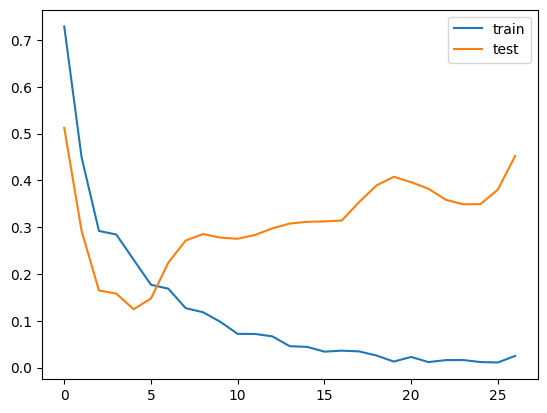

In [ ]:
from keras.callbacks import EarlyStopping

# Get the top N hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=5)
# Build the model with the best hp.
model = build_model(best_hps[0])

# Early stopping callback for parameter search
early_stopping_cb_training = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor during final training
    patience=25,          # Stop after 5 epochs of no improvement
    mode='max', # what to do to the objective performance measure specified in 'monitor'
    # min_delta = 0.5, # minimum change to performance metric to consider a change

    restore_best_weights=True
)

# Fit model
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=500, batch_size=96,callbacks=[early_stopping_cb_training], verbose=0)

# Evaluate the model
_, accuracy_train = model.evaluate(x_train, y_train, verbose=0)
_, accuracy_test  = model.evaluate(x_test, y_test, verbose=1)

print(f"Train accuracy: {accuracy_train * 100:.2f}% | Test accuracy: {accuracy_test * 100:.2f}%")

# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


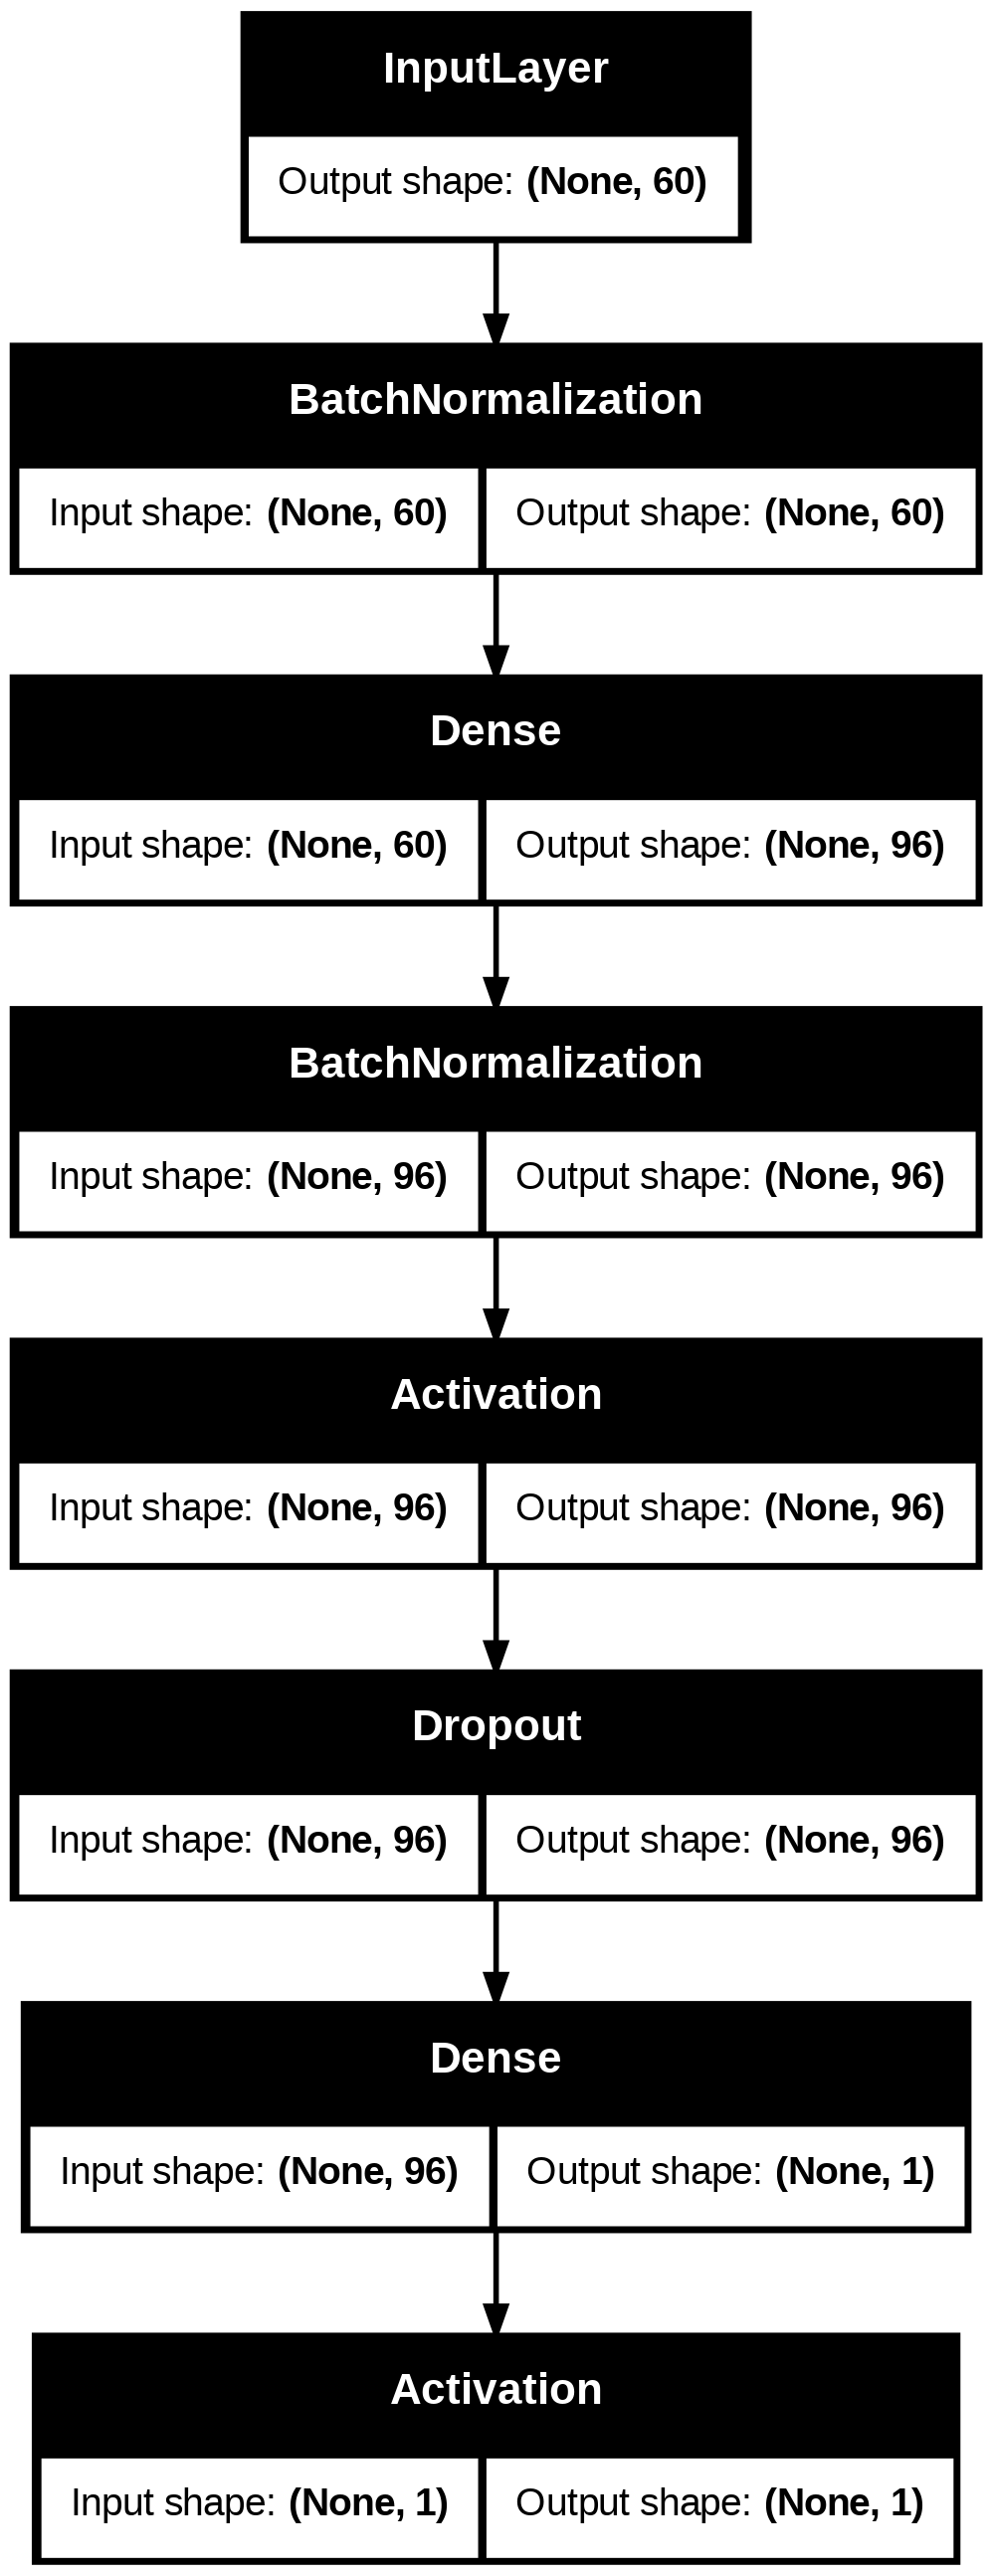

In [ ]:
# Plot model architecture
from tensorflow.keras.utils import plot_model

# Save model diagram as an image
plot_model(model, to_file="model_architecture.png", show_shapes=True)



In [ ]:
# Display detailed information about each layer
for i, layer in enumerate(model.layers):
    print(f"Layer {i + 1}: {layer.name}")
    print(f"  Type: {type(layer).__name__}")

    # Display configuration details specific to the layer type
    config = layer.get_config()
    for key, value in config.items():
        print(f"  {key}: {value}")

    print("-" * 50)

Layer 1: input_layer_5
  Type: InputLayer
  batch_shape: (None, 60)
  dtype: float32
  sparse: False
  name: input_layer_5
--------------------------------------------------
Layer 2: batch_normalization_10
  Type: BatchNormalization
  name: batch_normalization_10
  trainable: True
  dtype: {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}
  axis: -1
  momentum: 0.99
  epsilon: 0.001
  center: True
  scale: True
  beta_initializer: {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}
  gamma_initializer: {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}
  moving_mean_initializer: {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}
  moving_variance_initializer: {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}
  beta_regularizer: None
  gamma_regularizer: None
  

In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60)                  │             240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,353 (9.19 KB)

 Trainable params: 2,169 (8.47 KB)

 Non-trainable params: 184 (736.00 B)

# Keras Tuner Pseudo-workflow

In [ ]:
# for trial in 1 to max_trials:
#     hp = select_hyperparameters()
#     for execution in 1 to executions_per_trial:
#         model = build_model(hp)
#         for epoch in 1 to epochs:
#             model.update_weights()

(145, 60)

In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.3 MB/s eta 0:00:00
